Lecture notes

- Sample size: n
- Predictor dim: p
- Class numbers: k


1. Logistic regression
- logistic function p(X)
- log-odds (logit) is linear in X
- likelihood function: finding coefficients that maximize it. Number of coeff depends on predictor dim
- z-stats

2. Multiple logistic regression

3. Discriminant analysis
- Bayes' theorem
- posterior prob. p_k(x) depends on pi_k (prior prob., easy to compute from Y), and f_k(x) (desity function of X, hard to get from X, but can assume simple forms)
- when p=1
    - assume f_k(x,mu_k,sigma) are Gaussian with the same variance
    - the max of p_k(x) in k <=> the max of discriminant functions in k that is linear in x, which still depends on mu_k, sigma and pi_k
    - need estimate pi_k, mu_k and sigma from X and Y
    - Set pairs of discriminant functions equal to each other to determine Bayes decision boundary
    - Once have k for given x, we can compute p_k(x) for the probability
- when p>1
    - assume f_k(x,mu_k,Sigma) are Gaussian with the same covariance
    - algorithm same as p=1 case
- Forms of discriminant analysis
    - Linear: f_k(x) are Gaussian having the same covariance
    - Quatratic: f_k(x) are Gaussian having different covariance
    - Naive Bayes: X are independent in each class (covariance matrix is diagonal); useful for large p; useful for mixed feature vectors

4. Evaluate threshold value
- Confusion matrix
- True/False positive/negative
- Two types of error: True/False postitive rates
- The Total Error is a weighted average of the False Positive Rate and False Negative Rate. The weights are determined by the Prior Probabilities of Positive and Negative Responses.
- Visual method: ROC+AUC

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import findspark
from pyspark import SparkContext
from pyspark.sql import SparkSession, DataFrame, DataFrameReader
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.ml.classification import LogisticRegression, NaiveBayes
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.ml.evaluation import BinaryClassificationEvaluator,RegressionEvaluator, MulticlassClassificationEvaluator

%matplotlib inline

# change the path on your machine
findspark.init("/Users/lhd0430/Downloads/spark")

In [106]:
# Creat spark session
spark = SparkSession.builder \
   .master("local") \
   .appName("Linear Regression Model") \
   .config("spark.executor.memory", "1gb") \
   .getOrCreate()

In [107]:
# Load data as pyspark.sql.DataFrame
data = spark.read.csv("../data/Smarket.csv", header=True, inferSchema=True)
data.cache()
print(data.count())
data = data.dropna()
print(data.count())

1250
1250


In [108]:
# Convert lable to numeric type
data = data.replace(['Up','Down'],['1','0'],'Direction')
data = data.withColumn('Direction',data["Direction"].cast(DoubleType()))

0.07332176166857471
[-9.89192479477e-05,-0.0730437218623,-0.0423082784084,0.0110973714617,0.00935025229529,0.0103156159254,0.134698461518]
0.5386597145318075


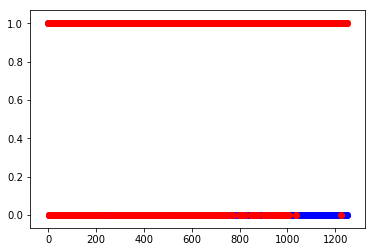

In [98]:
# Logistic Regression

# Convert feature to vector type
vecAssembler = VectorAssembler(inputCols=data.columns[:-2], outputCol="features")
df = vecAssembler.transform(data)

# Fit model
lr = LogisticRegression(featuresCol="features", labelCol="Direction")
ml = lr.fit(df)
print(ml.intercept)
print(ml.coefficients)

# Predict
predict = ml.transform(df)

# Evaluate
evaAUR = BinaryClassificationEvaluator(labelCol="Direction",metricName="areaUnderROC")
aur = evaAUR.evaluate(predict)
print(aur)
# confusion matrix is not available in ml at this moment

# Plot
pddf = predict.toPandas()

plt.figure()
plt.scatter(np.arange(0,len(pddf.Direction)),pddf.Direction,c='b')
plt.scatter(np.arange(0,len(pddf.Direction)),pddf.prediction,c='r')
plt.show()

In [109]:
# LDA - Naive Bayes

# Note: NB here requires data to be nonnegative!!!!

# Convert feature to vector type
vecAssembler = VectorAssembler(inputCols=data.columns[:-2], outputCol="features")
df = vecAssembler.transform(data)

# Fit model
nb = NaiveBayes(featuresCol="features", labelCol="Direction")
ml = nb.fit(df)

# Predict
predict = ml.transform(df)

# Evaluate
evaAcc = MulticlassClassificationEvaluator(labelCol="Direction",metricName="accuracy")
acc = evaAUR.evaluate(predict)
print(acc)
# confusion matrix is not available in ml at this moment

# Plot
pddf = predict.toPandas()

plt.figure()
plt.scatter(np.arange(0,len(pddf.Direction)),pddf.Direction,c='b')
plt.scatter(np.arange(0,len(pddf.Direction)),pddf.prediction,c='r')
plt.show()

Py4JJavaError: An error occurred while calling o2470.fit.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 0 in stage 11.0 failed 1 times, most recent failure: Lost task 0.0 in stage 11.0 (TID 11, localhost, executor driver): java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found [2001.0,0.381,-0.192,-2.624,-1.055,5.01,1.1913].
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:232)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:140)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:140)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:165)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:163)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$aggregateByKey$1$$anonfun$apply$6.apply(PairRDDFunctions.scala:172)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:144)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1599)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1587)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1586)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1586)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:831)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:831)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1820)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1769)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1758)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:642)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2027)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2048)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2067)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2092)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:939)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:363)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:938)
	at org.apache.spark.ml.classification.NaiveBayes.trainWithLabelCheck(NaiveBayes.scala:173)
	at org.apache.spark.ml.classification.NaiveBayes.train(NaiveBayes.scala:117)
	at org.apache.spark.ml.classification.NaiveBayes.train(NaiveBayes.scala:77)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:118)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:82)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: java.lang.IllegalArgumentException: requirement failed: Naive Bayes requires nonnegative feature values but found [2001.0,0.381,-0.192,-2.624,-1.055,5.01,1.1913].
	at scala.Predef$.require(Predef.scala:224)
	at org.apache.spark.ml.classification.NaiveBayes$.requireNonnegativeValues(NaiveBayes.scala:232)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:140)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$4.apply(NaiveBayes.scala:140)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:165)
	at org.apache.spark.ml.classification.NaiveBayes$$anonfun$7.apply(NaiveBayes.scala:163)
	at org.apache.spark.rdd.PairRDDFunctions$$anonfun$aggregateByKey$1$$anonfun$apply$6.apply(PairRDDFunctions.scala:172)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:189)
	at org.apache.spark.util.collection.ExternalSorter$$anonfun$5.apply(ExternalSorter.scala:188)
	at org.apache.spark.util.collection.AppendOnlyMap.changeValue(AppendOnlyMap.scala:144)
	at org.apache.spark.util.collection.SizeTrackingAppendOnlyMap.changeValue(SizeTrackingAppendOnlyMap.scala:32)
	at org.apache.spark.util.collection.ExternalSorter.insertAll(ExternalSorter.scala:194)
	at org.apache.spark.shuffle.sort.SortShuffleWriter.write(SortShuffleWriter.scala:63)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:109)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:345)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more


In [116]:
spark.stop()